In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

2024-04-29 07:34:16.103415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 07:34:16.103587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 07:34:16.212999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Load the DataFrame from the CSV file and images 
df = pd.read_csv('/kaggle/input/memotion-dataset/Memotion 3/updated_train.csv')
img_folder = '/kaggle/input/memotion-dataset/Memotion 3/trainImages'
target_shape = (224, 224)
images = []

# Define the value replacement mapping
replace_value = {
    'negative': 0,
    'very_negative': 0,
    'neutral': 1,
    'positive': 2,
    'very_positive': 2
}

df['overall'] = df['overall'].replace(replace_value)
min_count = df['overall'].value_counts().min()

# Downsample each group to have an equal number of samples
df = pd.concat([group.sample(min_count) for _, group in df.groupby('overall')])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
Y_train = df['overall']
#iterating over the dataframe if ocr is null drop the frame
for index,row in df.iterrows():
    img_path = os.path.join(img_folder, str(row['image_id'])+'.jpg')
    image = Image.open(img_path)
    image = image.resize(target_shape)
    images.append(image)
    
# Convert the resulting Series to a NumPy array
Y_train = np.array(Y_train, dtype=np.int32)
X_train = np.array(images)

/tmp/ipykernel_34/1801434636.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['overall'] = df['overall'].replace(replace_value)


In [10]:
#reading the validation data
df = pd.read_csv('/kaggle/input/memotion-dataset/Memotion 3/updated_val.csv')
img_folder = '/kaggle/input/memotion-dataset/Memotion 3/valImages'
Y_val = df['overall']
images=[]
#changing into numeric values
Y_val = Y_val.replace(replace_value);
Y_val = np.array(Y_val,dtype=np.int32)

for index,row in df.iterrows():
    img_path = os.path.join(img_folder, str(row['image_id'])+'.jpg')
    image = Image.open(img_path)
    image = image.resize(target_shape)
    images.append(image)
    
# Convert the resulting Series to a NumPy array
X_val = np.array(images)

/tmp/ipykernel_34/3766915548.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_val = Y_val.replace(replace_value);


In [11]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.optimizers import Adam

# Define your classes
num_classes = 3

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x) 
# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Preprocess the data
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# Train the model
model.fit(X_train, Y_train, batch_size=16, epochs=50, validation_data=(X_val, Y_val))


Epoch 1/50
  2/330 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.2812 - loss: 8.1529   

W0000 00:00:1714377080.029701     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3426 - loss: 9.3748

W0000 00:00:1714377113.747172     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


330/330 ━━━━━━━━━━━━━━━━━━━━ 76s 169ms/step - accuracy: 0.3426 - loss: 9.3640 - val_accuracy: 0.3507 - val_loss: 1.5981
Epoch 2/50
  1/330 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - accuracy: 0.9375 - loss: 0.4356

W0000 00:00:1714377135.517620     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.8810 - loss: 0.3855 - val_accuracy: 0.3293 - val_loss: 1.9424
Epoch 3/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.9845 - loss: 0.1345 - val_accuracy: 0.3460 - val_loss: 1.9931
Epoch 4/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9854 - loss: 0.1041 - val_accuracy: 0.3327 - val_loss: 2.0199
Epoch 5/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.9866 - loss: 0.0943 - val_accuracy: 0.3067 - val_loss: 2.3952
Epoch 6/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.9888 - loss: 0.1069 - val_accuracy: 0.3480 - val_loss: 2.2007
Epoch 7/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - accuracy: 0.9908 - loss: 0.1075 - val_accuracy: 0.3173 - val_loss: 2.2785
Epoch 8/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9895 - loss: 0.1045 - val_accuracy: 0.3267 - val_loss: 2.3107
Epoch 9/50
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - accuracy: 0.9908 - loss: 0.1161 - val

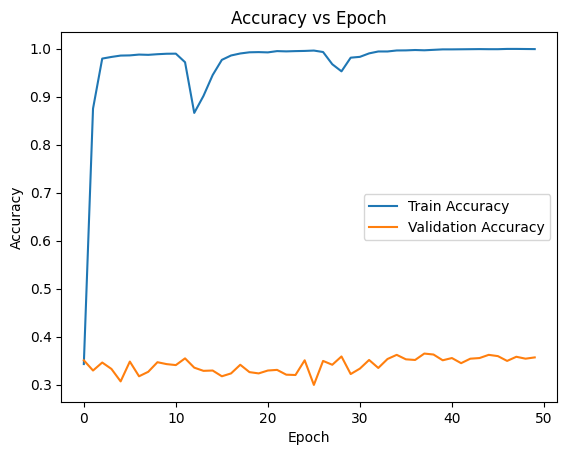

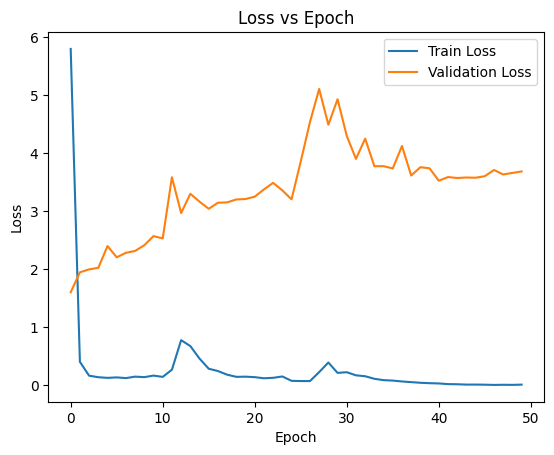

In [12]:
# Plot accuracy vs epoch
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss vs epoch
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming X_test is your numpy array of test images and Y_test are the corresponding labels
# Assuming X_test has shape (num_samples, 224, 224, 3) and Y_test has shape (num_samples,)
# Make predictions
Y_pred = model.predict(X_val)

# Convert probabilities to class labels
predicted_labels = np.argmax(Y_pred, axis=1)

# Evaluate accuracy
accuracy = accuracy_score(Y_val, predicted_labels)

# Calculate F1 score
f1 = f1_score(Y_val, predicted_labels, average='weighted')

# Calculate precision
precision = precision_score(Y_val, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(Y_val, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step 

W0000 00:00:1714379211.306808     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 820ms/step
Accuracy: 0.3566666666666667
F1 Score: 0.3600471709576973
Precision: 0.3722867924636519
Recall: 0.3566666666666667


W0000 00:00:1714379249.006607     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
